# Evaluate Stanford Quality Control Criteria
Code author: Sahar H. El Abbadi
Date started: 2022-03-02
Date last edited: 2022-03-13

In [1]:
# Setup
import numpy as np
import pandas as pd
import pathlib

# Imports
from methods_source import summarize_qc
from plot_methods import plot_qc_summary

## Compare Operator vs Stanford QC

In [2]:
# Carbon Mapper QC
cm_1_qc = summarize_qc(operator = "Carbon Mapper", stage=1, strict_discard=False)
cm_2_qc = summarize_qc(operator = "Carbon Mapper", stage=2, strict_discard=False)
cm_3_qc = summarize_qc(operator = "Carbon Mapper", stage=3, strict_discard=False)

In [3]:
# GHGSat QC
ghg_1_qc = summarize_qc(operator = "GHGSat", stage=1, strict_discard=False)
ghg_2_qc = summarize_qc(operator = "GHGSat", stage=2, strict_discard=False)
ghg_3_qc = summarize_qc(operator = "GHGSat", stage=3, strict_discard=False)


In [4]:
# Kairos
kairos_1_qc = summarize_qc(operator = "Kairos", stage=1, strict_discard=False)
kairos_2_qc = summarize_qc(operator = "Kairos", stage=2, strict_discard=False)
kairos_3_qc = summarize_qc(operator = "Kairos", stage=3, strict_discard=False)

In [5]:
# Kairos LS23
kairos_ls23_1_qc = summarize_qc(operator = "Kairos LS23", stage=1, strict_discard=False)
kairos_ls23_2_qc = summarize_qc(operator = "Kairos LS23", stage=2, strict_discard=False)
kairos_ls23_3_qc = summarize_qc(operator = "Kairos LS23", stage=3, strict_discard=False)

In [6]:
# Kairos LS25
kairos_ls25_1_qc = summarize_qc(operator = "Kairos LS25", stage=1, strict_discard=False)
kairos_ls25_2_qc = summarize_qc(operator = "Kairos LS25", stage=2, strict_discard=False)
kairos_ls25_3_qc = summarize_qc(operator = "Kairos LS25", stage=3, strict_discard=False)


In [7]:
# Combine all individual QC dataframes

all_qc = [cm_1_qc, cm_2_qc, cm_3_qc, ghg_1_qc, ghg_2_qc, ghg_3_qc, kairos_1_qc, kairos_2_qc, kairos_3_qc, kairos_ls23_1_qc, kairos_ls23_2_qc, kairos_ls23_3_qc, kairos_ls25_1_qc, kairos_ls25_2_qc, kairos_ls25_3_qc]

all_qc = pd.concat(all_qc)
all_qc.to_csv(pathlib.PurePath('03_results', 'qc_comparison', 'all_qc.csv'))

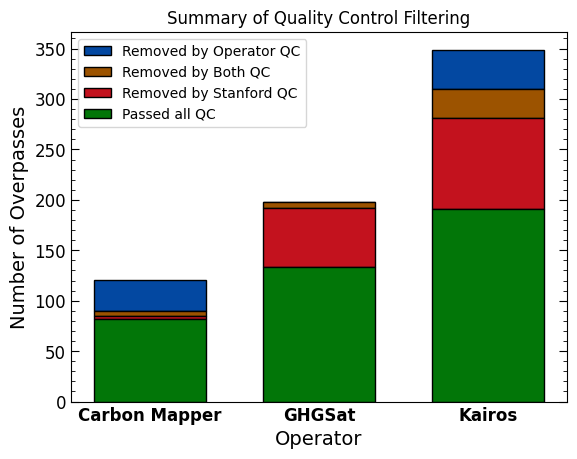

In [8]:
# Make bar pot summarizing QC results
operators = ['Carbon Mapper', 'GHGSat', 'Kairos']
stage = 1
plot_qc_summary(operators, stage)

### QC Filter and error profile

Compare strict and non-strict QC filters and error profile for operators.

In [76]:
# setup
from methods_source import load_overpass_summary
import pandas as pd
import numpy as np
import math

# Load overpass summary files with and without strict discard
operator = 'Carbon Mapper'
stage = 1
strict_discard = False
op_lax = load_overpass_summary(operator=operator, stage=stage, strict_discard=strict_discard)

# Set strict_discard to True
strict_discard = True
op_strict = load_overpass_summary(operator=operator, stage=stage, strict_discard=strict_discard)

# Make dataframe for summarizing error profile

op_error = pd.DataFrame()

# Load columns that are the same in both strict and lax overpass summaries:
op_error['overpass_id'] = op_lax['overpass_id']
op_error['zero_release'] = op_lax['zero_release']
op_error['operator_kept'] = op_lax['operator_kept']
op_error['operator_detected'] = op_lax['operator_detected']
op_error['operator_quantified'] = op_lax['operator_quantification'].notna()
op_error['operator_quantification'] = op_lax['operator_quantification']
op_error['release_rate_kgh'] = op_lax['release_rate_kgh']

# Load columns that change in strict vs lax overpass summaries
op_error['stanford_kept_strict'] = op_strict['stanford_kept']
op_error['qc_summary_strict'] = op_strict['qc_summary']
op_error['stanford_kept_lax'] = op_lax['stanford_kept']
op_error['qc_summary_lax'] = op_lax['qc_summary']

Determine the percent error for the overpasses that pass in both strict and lax criteria:
$$
    Percent Error = \frac{(operator\_quantification) - (release\_rate\_kgh)}{release\_rate\_kgh}
$$



In [77]:
def calc_percent_error (observed, expected):
    # don't divide by zero:
    if expected == 0:
        return np.nan

    # keep overpasses that aren't quantified in series so it can be aligned later
    if pd.isnull(observed):
        return np.nan
    else:
        return ((observed - expected) / expected) * 100

# Calculate percent error for all overpasses
percent_error = op_error.apply(lambda x: calc_percent_error(x['operator_quantification'], x['release_rate_kgh']), axis=1)

### Mean percent error for Carbon Mapper overpasses

#### Strict discard criteria
- QC criteria: strict discard (1% mass of previous 10-minutes allowed within distance threshold)
- Overpass must have passed Carbon Mapper QC
- Remove all zero releases

In [78]:
op_error['percent_error'] = percent_error
op_error_pass_strict = op_error.query('qc_summary_strict == "pass_all"')
op_error_pass_strict = op_error_pass_strict.query('operator_quantified == True')
pass_strict_mean_error = op_error_pass_strict.percent_error.mean()
print(f'Mean percent error is: {pass_strict_mean_error:.2f}%')

Mean percent error is: 20.91%


#### Lax discard criteria
- QC criteria: lax discard (10% mass of previous 10-minutes allowed within distance threshold)
- Overpasses must have passed Carbon Mapper QC
- Remove all zero releases

In [79]:
op_error_pass_lax = op_error.query('qc_summary_lax == "pass_all"')
op_error_pass_lax= op_error_pass_lax.query('operator_quantified == True')
pass_lax_mean_error = op_error_pass_lax.percent_error.mean()
print(f'Mean percent error is: {pass_lax_mean_error:.2f}%')


Mean percent error is: 24.88%


In [87]:
from scipy.stats.mstats import ttest_ind

t_stat, p_value = ttest_ind(op_error_pass_strict.percent_error, op_error_pass_lax.percent_error, equal_var=True)
if p_value <= 0.05:
    print(f'Calculated p-value of {p_value:0.4f} is less than 0.05, the difference is considered statistically significant.')
else:
    print(f'Calculated p-value of {p_value:0.4f} is greater than 0.05, the difference is not considered statisticaly significant.')

Calculated p-value of 0.8240 is greater than 0.05, the difference is not considered statisticaly significant.
